In [30]:
import pandas as pd

pd.set_option("display.max_columns", None)  # Toont alle kolommen
pd.set_option("display.width", 100)  # Voorkomt afkapping van kolommen
pd.set_option("display.max_rows", 1400)  # Beperkt aantal rijen om overzichtelijk te blijven

In [31]:
df_Full_dataset = pd.read_csv('TEG_Data&Weather_2Years_WithNAN.csv')

In [ ]:
import pandas as pd

df = df_Full_dataset

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Month'] = df['Timestamp'].dt.month

In [ ]:
import numpy as np
import pandas as pd

df = df_Full_dataset.copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.set_index("Timestamp").sort_index()

df["Energy_lag_1"] = df["Energy (J)"].shift(1)
df["Energy_lag_2"] = df["Energy (J)"].shift(2)
df["Moving_average_energy_3"] = df["Energy (J)"].shift(1).rolling(window=3).mean()

df["Direct_radiation_lag_1"] = df["direct_rad:W"].shift(1)
df["Direct_radiation_lag_2"] = df["direct_rad:W"].shift(2)
df["Moving_average_direct_radiation_3"] = df["direct_rad:W"].shift(1).rolling(window=3).mean()

df["Ambient_Temperature_lag_1"] = df["Ambient_Temperature"].shift(1)
df["Ambient_Temperature_lag_2"] = df["Ambient_Temperature"].shift(2)
df["Moving_average_Ambient_Temperature_3"] = df["Ambient_Temperature"].shift(1).rolling(window=3).mean()

df["Ground_50cm_Temperature_lag_1"] = df["Ground_50cm_Temperature"].shift(1)
df["Ground_50cm_Temperature_lag_2"] = df["Ground_50cm_Temperature"].shift(2)
df["Moving_average_Ground_50cm_Temperature_3"] = df["Ground_50cm_Temperature"].shift(1).rolling(window=3).mean()

df["Hour_direct_interaction"] = df["Hour"] * df["direct_rad:W"]

# Targets
df["Energy_sum_target_30minutes"] = df["Energy (J)"].shift(-5).rolling(window=6, min_periods=6).sum()
df["Energy_sum_target_1hour"] = df["Energy (J)"].shift(-11).rolling(window=12, min_periods=12).sum()
df["Energy_sum_target_6hours"] = df["Energy (J)"].shift(-66).rolling(window=72, min_periods=72).sum()
df["Energy_sum_target_12hours"] = df["Energy (J)"].shift(-132).rolling(window=144, min_periods=144).sum()
df["Energy_sum_target_24hours"] = df["Energy (J)"].shift(-264).rolling(window=288, min_periods=288).sum()

YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()



In [ ]:
import numpy as np, pandas as pd, math, warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")

# 1. Features & target
features = [
    "direct_rad:W","Direct_radiation_lag_1","Direct_radiation_lag_2",
    "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature","Ground_50cm_Temperature_lag_1",
    "Ground_50cm_Temperature_lag_2","Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature",
    "Energy_lag_1","Energy_lag_2","Moving_average_energy_3",
    "Hour","Month",

    "precip_5min:mm",
    "dew_point_2m:C",
    "relative_humidity_2m:p",
    "visibility:m",
    "wind_dir_10m:d",
    "wind_speed_10m:ms",
    "sfc_pressure:Pa"
]
target = "Energy_sum_target_1hour"

# 2. Train-validatie splitsing 
split_ix = int(len(YEAR1) * 0.8)
train_df = YEAR1.iloc[:split_ix]
val_df   = YEAR1.iloc[split_ix:]

X_train, y_train = train_df[features], train_df[target]
X_val  , y_val   = val_df[features] , val_df[target]

# 3. Pipeline + RandomizedSearchCV
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1))
])

param_space = {
    "xgb__n_estimators":      [400, 600, 800, 1000],
    "xgb__max_depth":        [3, 5, 7],
    "xgb__learning_rate":    [0.01, 0.03, 0.05, 0.1],
    "xgb__subsample":        [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__gamma":            [0, 0.05, 0.1],
    "xgb__min_child_weight": [1, 3, 5]
}

split_arr = np.r_[np.full(len(X_train), -1), np.zeros(len(X_val))]
ps = PredefinedSplit(split_arr)

X_search = pd.concat([X_train, X_val])
y_search = pd.concat([y_train, y_val])

search = RandomizedSearchCV(
    pipe, param_space,
    cv=ps, n_iter=25,
    scoring="neg_mean_absolute_error",
    n_jobs=-1, verbose=1, random_state=42
).fit(X_search, y_search)

print("\nBeste hyperparameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

# 4. Validatie-resultaten (80/20)
best_model = search.best_estimator_

def metr(y_true, y_pred):
    return (mean_absolute_error(y_true, y_pred),
            math.sqrt(mean_squared_error(y_true, y_pred)),
            r2_score(y_true, y_pred))

mae_tr, rmse_tr, r2_tr = metr(y_train, best_model.predict(X_train))
mae_v , rmse_v , r2_v  = metr(y_val,   best_model.predict(X_val))

print("\n80-/20-split resultaten")
print(f"  TRAIN  MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
print(f"  VAL    MAE {mae_v :.3f} | RMSE {rmse_v :.3f} | R² {r2_v :.3f}")


# 5. Definitief model op heel jaar 1
final_model = search.best_estimator_
final_model.fit(YEAR1[features], YEAR1[target])

# 6. Seizoens-evaluatie (jaar 2)
season_blocks = [
    ("Herfst 23",   "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Lente 24",    "2024-03-01", "2024-05-31"),
    ("Zomer 24",    "2024-06-01", "2024-08-31"),
]

mae_l, rmse_l, r2_l = [], [], []
print("\nSeizoens-scores (jaar 2)")

for name, d1, d2 in season_blocks:
    block = YEAR2.loc[d1:d2]
    if block.empty:
        print(f"{name:10s} – geen rijen in deze periode")
        continue

    y_true = block[target]
    y_pred = final_model.predict(block[features])

    mae, rmse, r2 = metr(y_true, y_pred)
    mae_l.append(mae); rmse_l.append(rmse); r2_l.append(r2)

    print(f"{name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

if mae_l:
    print("\nGemiddeld over vier seizoenen")
    print(f"  MAE  {np.mean(mae_l):.3f}")
    print(f"  RMSE {np.mean(rmse_l):.3f}")
    print(f"  R²   {np.mean(r2_l):.3f}")


Fitting 1 folds for each of 25 candidates, totalling 25 fits

Beste hyperparameters:
  xgb__subsample: 1.0
  xgb__n_estimators: 800
  xgb__min_child_weight: 5
  xgb__max_depth: 5
  xgb__learning_rate: 0.01
  xgb__gamma: 0.05
  xgb__colsample_bytree: 1.0

80-/20-split resultaten
  TRAIN  MAE 0.143 | RMSE 0.404 | R² 0.962
  VAL    MAE 0.200 | RMSE 0.555 | R² 0.967

Seizoens-scores (jaar 2)
Herfst 23   MAE 0.120 | RMSE 0.266 | R² 0.894
Winter 23/24  MAE 0.061 | RMSE 0.183 | R² 0.850
Lente 24    MAE 0.348 | RMSE 1.087 | R² 0.870
Zomer 24    MAE 0.412 | RMSE 1.178 | R² 0.881

Gemiddeld over vier seizoenen
  MAE  0.235
  RMSE 0.678
  R²   0.874


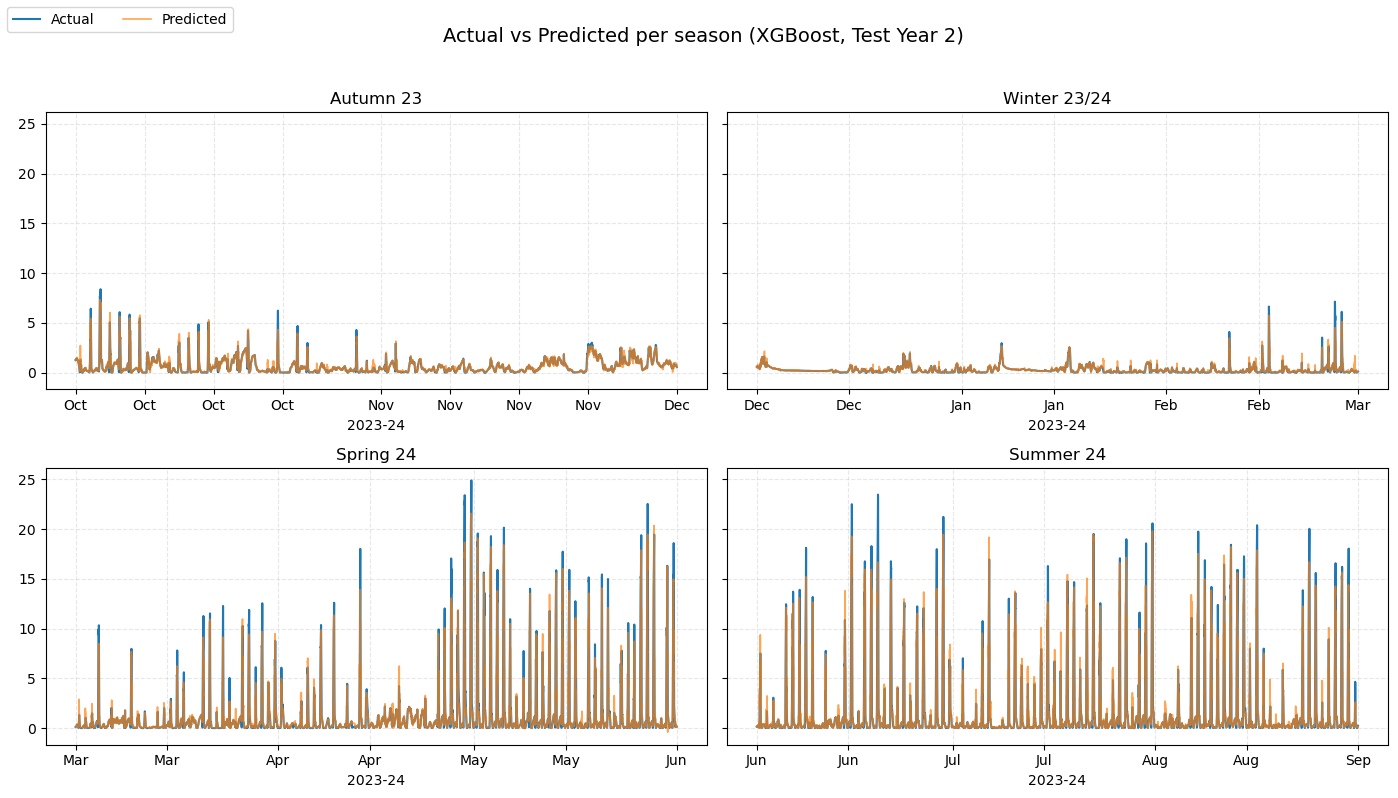

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.ravel()

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    block = YEAR2.loc[d1:d2]
    if block.empty:
        ax.set_visible(False)
        continue

    y_true = block[target]
    y_pred = final_model.predict(block[features])

    ax.plot(block.index, y_true, label="Actual", linewidth=1.5)
    ax.plot(block.index, y_pred, label="Predicted", linewidth=1.2, alpha=0.7)

    ax.set_title(title, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlabel("2023-24")
    ax.grid(True, linestyle="--", alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2)

fig.suptitle("Actual vs Predicted per season (XGBoost, Test Year 2)", y=0.97, fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


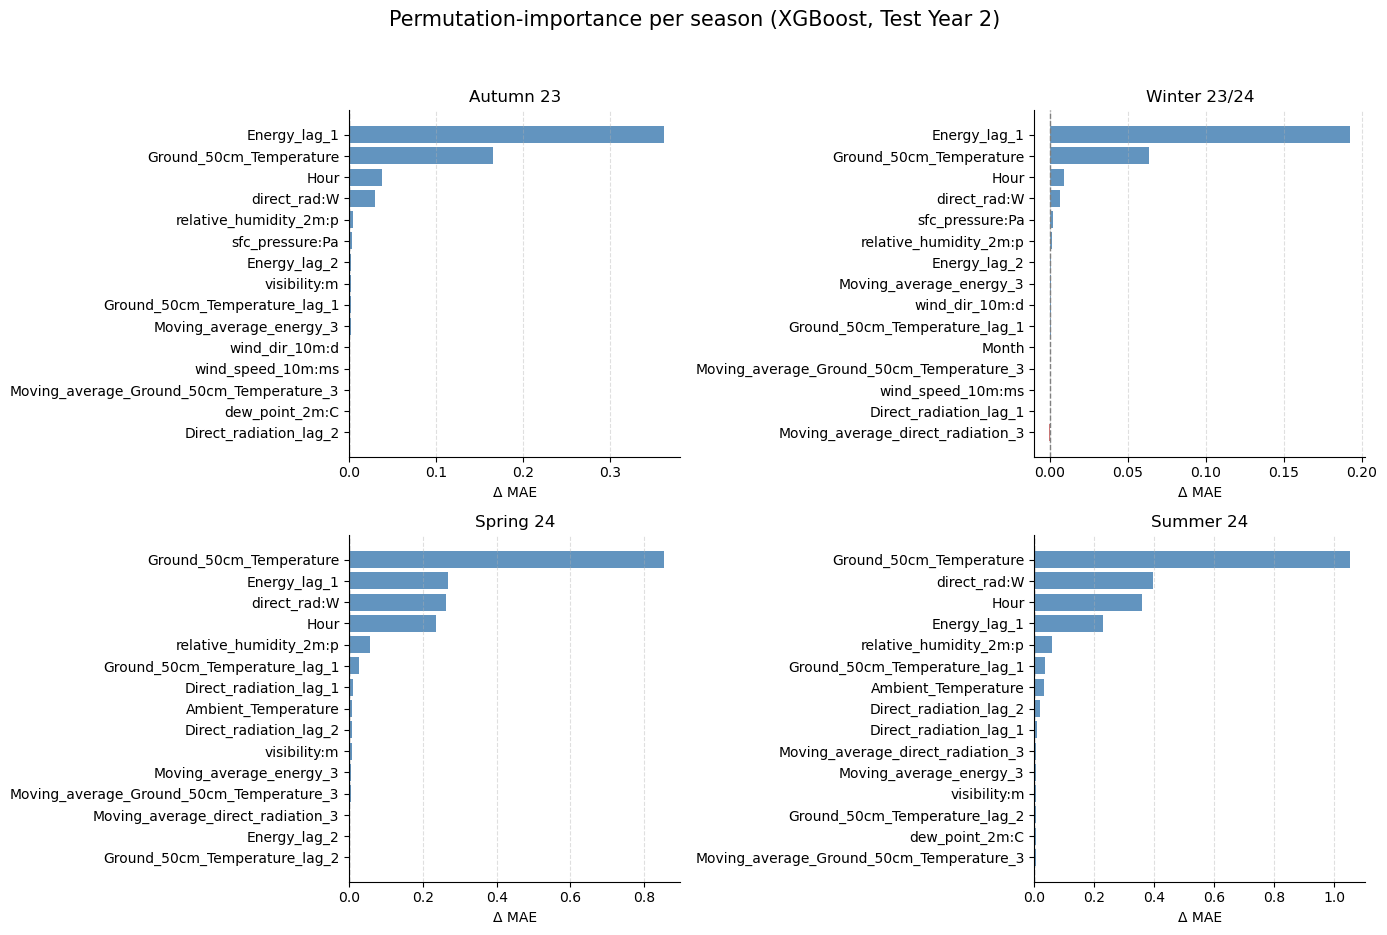

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.inspection import permutation_importance


# 1. Importance DataFrame 
def importance_df(model, X, y, k=15, repeats=10):
    imp = permutation_importance(
        model, X, y,
        scoring="neg_mean_absolute_error",
        n_repeats=repeats, random_state=42, n_jobs=-1
    )
    delta = imp.importances_mean                     # baseline − permuted
    order = np.argsort(np.abs(delta))[::-1][:k]      # top-k op impact

    df_imp = pd.DataFrame({
        "feature": X.columns[order],
        "delta_mae": delta[order]
    }).sort_values("delta_mae")  # voor barh: van onder naar boven

    return df_imp

# 2. Engelse seizoen-blokken en subplot-grid
season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False)
axes = axes.ravel()

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    blk = YEAR2.loc[d1:d2]
    if blk.empty:
        ax.axis("off")
        ax.set_title(f"{title}\n(no data)")
        continue

    imp_df = importance_df(final_model, blk[features], blk[target], k=15, repeats=10)

    
    colors = ["indianred" if x < 0 else "steelblue" for x in imp_df["delta_mae"]]

    ax.barh(imp_df["feature"], imp_df["delta_mae"], color=colors, alpha=0.85)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Δ MAE")

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.suptitle("Permutation-importance per season (XGBoost, Test Year 2)", fontsize=15, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


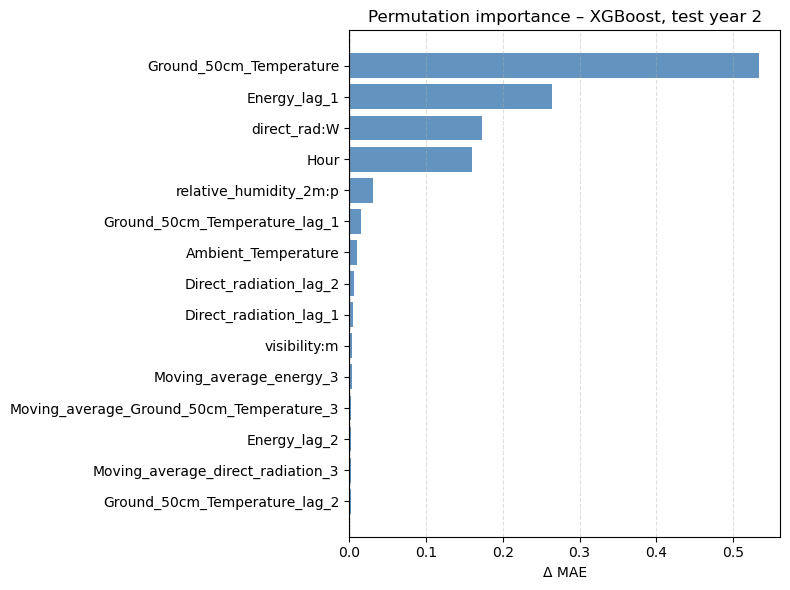

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def imp_one_block(model, X, y, repeats=10):
    imp = permutation_importance(
        model, X, y,
        scoring="neg_mean_absolute_error",
        n_repeats=repeats,
        random_state=42,
        n_jobs=-1
    )
    return imp.importances_mean  

season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

impact_dict = {f: [] for f in features}

for _, d1, d2 in season_blocks_en:
    blk = YEAR2.loc[d1:d2]
    if blk.empty:
        continue
    delta_mae = imp_one_block(final_model, blk[features], blk[target])
    for f, imp_val in zip(features, delta_mae):
        impact_dict[f].append(imp_val)

avg_imp = {f: np.mean(v) for f, v in impact_dict.items() if v}
imp_series = pd.Series(avg_imp)

top_imp = imp_series.reindex(
    imp_series.abs().sort_values(ascending=False).index
).head(15).sort_values()

colors = ["indianred" if v < 0 else "steelblue" for v in top_imp]


plt.figure(figsize=(8, 6))
plt.barh(top_imp.index, top_imp.values, color=colors, alpha=0.85)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Δ MAE")
plt.title("Permutation importance – XGBoost, test year 2")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, pandas as pd, math, warnings
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
warnings.filterwarnings("ignore")

# Forecast horizons
horizons = {
    "30minutes":  (5, 6),
    "1hour":      (11, 12),
    "6hours":     (66, 72),
    "12hours":    (132, 144),
    "24hours":    (264, 288)
}

for label, (shift_n, roll_n) in horizons.items():
    df[f"Energy_sum_target_{label}"] = (
        df["Energy (J)"].shift(-shift_n).rolling(window=roll_n, min_periods=roll_n).sum()
    )

# Splitsen per jaar, daarna pas dropna
YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()

# 2. Features
features = [
    "direct_rad:W","Direct_radiation_lag_1","Direct_radiation_lag_2",
    "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature","Ground_50cm_Temperature_lag_1",
    "Ground_50cm_Temperature_lag_2","Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature",
    "Energy_lag_1","Energy_lag_2","Moving_average_energy_3",
    "Hour","Month",

    "precip_5min:mm",
    "dew_point_2m:C",
    "relative_humidity_2m:p",
    "visibility:m",
    "wind_dir_10m:d",
    "wind_speed_10m:ms",
    "sfc_pressure:Pa"
]

# 3. Seizoensblokken (jaar 2)
season_blocks = [
    ("Herfst 23",   "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Lente 24",    "2024-03-01", "2024-05-31"),
    ("Zomer 24",    "2024-06-01", "2024-08-31"),
]


# 4. Gebruik vaste hyperparameters voor alle horizons
best_params_1hour = {
    "n_estimators": 800,
    "max_depth": 5,
    "learning_rate": 0.01,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "gamma": 0.05,
    "min_child_weight": 5
}

results = {}

for label in horizons.keys():
    print(f"\n🔁 Voorspelhorizon: {label}")
    target = f"Energy_sum_target_{label}"

    # Train/val splits
    split_ix = int(len(YEAR1) * 0.8)
    train_df = YEAR1.iloc[:split_ix]
    val_df   = YEAR1.iloc[split_ix:]

    X_train, y_train = train_df[features], train_df[target]
    X_val  , y_val   = val_df[features] , val_df[target]

    # Model pipeline met vaste params
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("xgb", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
            **best_params_1hour
        ))
    ])

    model = pipe.fit(X_train, y_train)

    # Evaluatie op train/val
    def metr(y_true, y_pred):
        return (mean_absolute_error(y_true, y_pred),
                math.sqrt(mean_squared_error(y_true, y_pred)),
                r2_score(y_true, y_pred))

    mae_tr, rmse_tr, r2_tr = metr(y_train, model.predict(X_train))
    mae_v , rmse_v , r2_v  = metr(y_val,   model.predict(X_val))

    print(f"  TRAIN   MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
    print(f"  VAL     MAE {mae_v :.3f} | RMSE {rmse_v :.3f} | R² {r2_v :.3f}")

    # Definitief model trainen op heel jaar 1
    final_model = pipe.fit(YEAR1[features], YEAR1[target])

    # Seizoens-evaluatie in jaar 2
    print(f"  Seizoensscores (jaar 2)")
    season_mae, season_rmse, season_r2 = [], [], []

    for name, d1, d2 in season_blocks:
        block = YEAR2.loc[d1:d2]
        if block.empty:
            print(f"    {name:10s} – geen rijen")
            continue

        y_true = block[target]
        y_pred = final_model.predict(block[features])

        mae, rmse, r2 = metr(y_true, y_pred)
        season_mae.append(mae)
        season_rmse.append(rmse)
        season_r2.append(r2)

        print(f"    {name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

    results[label] = {
    "train_mae": mae_tr,
    "train_rmse": rmse_tr,
    "train_r2": r2_tr,

    "val_mae": mae_v,
    "val_rmse": rmse_v,
    "val_r2": r2_v,

    "test_mae": np.mean(season_mae),
    "test_rmse": np.mean(season_rmse),
    "test_r2": np.mean(season_r2),

    "model": final_model
    }


# 5. Samenvattende tabel
print("\n📊 Samenvatting per horizon (alle scores):")

summary = pd.DataFrame([
    {
        "Horizon": k,
        "Train MAE": v["train_mae"],
        "Train RMSE": v["train_rmse"],
        "Train R²": v["train_r2"],

        "Val MAE": v["val_mae"],
        "Val RMSE": v["val_rmse"],
        "Val R²": v["val_r2"],

        "Test MAE": v["test_mae"],
        "Test RMSE": v["test_rmse"],
        "Test R²": v["test_r2"],
    }
    for k, v in results.items()
])

print(summary.round(3))





🔁 Voorspelhorizon: 30minutes
  TRAIN   MAE 0.053 | RMSE 0.165 | R² 0.976
  VAL     MAE 0.113 | RMSE 0.364 | R² 0.947
  Seizoensscores (jaar 2)
    Herfst 23   MAE 0.043 | RMSE 0.110 | R² 0.932
    Winter 23/24  MAE 0.019 | RMSE 0.068 | R² 0.922
    Lente 24    MAE 0.130 | RMSE 0.446 | R² 0.917
    Zomer 24    MAE 0.153 | RMSE 0.493 | R² 0.920

🔁 Voorspelhorizon: 1hour
  TRAIN   MAE 0.135 | RMSE 0.372 | R² 0.968
  VAL     MAE 0.296 | RMSE 0.889 | R² 0.916
  Seizoensscores (jaar 2)
    Herfst 23   MAE 0.120 | RMSE 0.266 | R² 0.894
    Winter 23/24  MAE 0.061 | RMSE 0.183 | R² 0.850
    Lente 24    MAE 0.348 | RMSE 1.087 | R² 0.870
    Zomer 24    MAE 0.412 | RMSE 1.178 | R² 0.881

🔁 Voorspelhorizon: 6hours
  TRAIN   MAE 1.301 | RMSE 2.672 | R² 0.916
  VAL     MAE 3.211 | RMSE 6.208 | R² 0.774
  Seizoensscores (jaar 2)
    Herfst 23   MAE 1.431 | RMSE 2.262 | R² 0.634
    Winter 23/24  MAE 0.738 | RMSE 1.376 | R² 0.621
    Lente 24    MAE 3.126 | RMSE 6.606 | R² 0.749
    Zomer 24    MAE